In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pyro
import numpy as np
import pylab as pl
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyro import distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.mcmc import MCMC, HMC, NUTS
import seaborn as sns

sns.set_theme()

from scripts import *
from models import *

## Data Exploration

In [3]:
# Import the dataset and remove id column
data = pd.read_csv("../Datasets/cardiovascular_disease.csv", sep=";")
data.drop("id", axis=1, inplace=True)

In [4]:
# Check if data contains null values
data.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


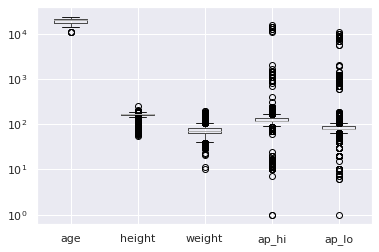

In [6]:
data[["age", "height", "weight", "ap_hi", "ap_lo"]].boxplot()
pl.yscale("log")

From both the boxplot and the summary we see that some entries have unrealistic values, for example blood pressures higher than 1000 or even negative, furthermore a person with height of 250 cm doesn't exist in the world.  
We now proceed to remove these outliers

## Data cleaning

In [7]:
ap_hi_filter = np.any([data["ap_hi"] > 250, data["ap_hi"] < 50], 0)
ap_lo_filter = np.any([data["ap_lo"] > 210, data["ap_lo"] < 30], 0)
height_filter = data["height"] > 230

data_filter = np.any([ap_lo_filter, ap_hi_filter, height_filter], 0)

print(f"Number of outliers: {data_filter.sum()}")

Number of outliers: 1220


In [8]:
data = data[~data_filter]

We decided to remove the outliers since we have a lot of data

In [9]:
# Split into train and test set

X, y = data.iloc[:, :-1], data.iloc[:, -1]

X, y = dataframe_to_tensor(X), dataframe_to_tensor(y, normalize=False)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

## Define a model

### Bayesian logistic regression

In [10]:
model = BayesianLogisticRegression().fit(x_train, y_train)

Sample: 100%|██████████| 600/600 [00:06, 87.65it/s, step size=5.13e-01, acc. prob=0.912] 


In [11]:
model.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]      0.34      0.01      0.34      0.33      0.36       nan      1.03
      w[1]     -0.02      0.02     -0.02     -0.04      0.01       nan      0.99
      w[2]     -0.01      0.02     -0.01     -0.03      0.01       nan      1.00
      w[3]      0.14      0.02      0.14      0.11      0.17       nan      0.99
      w[4]      0.90      0.02      0.90      0.85      0.92       nan      1.01
      w[5]      0.16      0.02      0.16      0.12      0.19       nan      1.02
      w[6]      0.34      0.02      0.34      0.32      0.37       nan      0.99
      w[7]     -0.06      0.02     -0.06     -0.09     -0.04       nan      1.00
      w[8]     -0.04      0.01     -0.04     -0.07     -0.02       nan      0.99
      w[9]     -0.05      0.02     -0.05     -0.07     -0.03       nan      1.00
     w[10]     -0.09      0.01     -0.09     -0.12     -0.07       nan      0.99
         b      0.02      0

/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/infer/mcmc/util.py:416: UserWarning: Traceback (most recent call last):
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/infer/mcmc/util.py", line 414, in wrapped
    val = fn(sample, *args, **kwargs)
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/ops/stats.py", line 184, in effective_sample_size
    gamma_k_c = autocovariance(input, dim=0)  # N x C x sample_shape
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/ops/stats.py", line 135, in autocovariance
    return autocorrelation(input, dim) * input.var(dim, unbiased=False, keepdim=True)
  File "/home/lettera/anaconda3/lib/python3.8/site-packages/pyro/ops/stats.py", line 112, in autocorrelation
    freqvec = torch.rfft(centered_signal, signal_ndim=1, onesided=False)
AttributeError: module 'torch' has no attribute 'rfft'

  warnings.warn(tb.format_exc())


In [12]:
model.score(x_test, y_test)

General Accuracy:  0.7275370747310265
Class 0: accuracy 0.7895915905566087, support: 17409
Class 1: accuracy 0.6639184971438666, support: 16981


### Classical neural network

In [22]:
net = MLP(11, n_classes=2, num_layers=3, hidden_size=64, device="cuda", activation=nn.GELU)
train_data = MatrixLoader(x_train, y_train.long())
test_data = MatrixLoader(x_test, y_test.long())
train_loader = DataLoader(train_data, batch_size=2048)
test_loader = DataLoader(test_data, batch_size=4096)

optimizer = torch.optim.Adam(net.parameters(), lr=0.0025549527865318215)
criterion = nn.CrossEntropyLoss()

net.fit(train_loader, optimizer, criterion, n_epochs=10)

17
Epoch: 10	 loss: 0.5405835894977346	 time: 0.21886920928955078


In [23]:
net.accuracy(test_loader)

tensor(0.7348, device='cuda:0')

### Bayesian netural network

In [17]:
# I use bayesian optimization to find the best hyperparameters
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from time import time

space  = [Integer(64, 4096, "log-uniform", name='batch_size'),
          Real(10**-5, 10**0, "log-uniform", name='lr'),
          Integer(1, 5, name='num_layers'),
          Integer(1, 128, "log-uniform", name='hidden_size'),
          Categorical([nn.ReLU, nn.SiLU, nn.LeakyReLU], name='activation')]

@use_named_args(space)
def objective(**params):
    start = time()
    device = "cpu"
    if params["batch_size"] > 128 and params["hidden_size"] > 128:
        device = "cuda"
        
    net = MLP(11, device=device,
              num_layers=params["num_layers"],
              hidden_size=params["hidden_size"],
              activation=params["activation"])
    bayesian_net = BayesianNetwork(net)
    
    train_loader = DataLoader(train_data, batch_size=params["batch_size"].item())
    optimizer = pyro.optim.ClippedAdam({"lr":params["lr"]})
    elbo = Trace_ELBO()
    bayesian_net.fit(train_loader, optimizer, elbo, n_epochs=10)
    
    return (1-bayesian_net.accuracy(test_loader, n_samples=10)).item(), time()-start

res_gp = gp_minimize(objective, space, acq_func='EIps', n_calls=10, verbose=True)

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.1928
Function value obtained: 0.4954
Current minimum: 0.3051


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

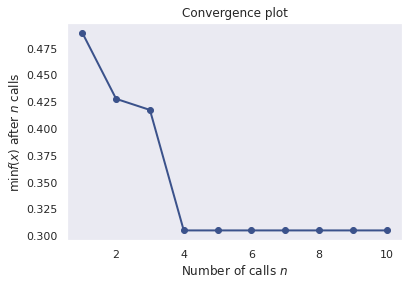

In [18]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [19]:
res_gp.x

[3735, 0.0034550520899127527, 3, 124, torch.nn.modules.activation.LeakyReLU]

### Bayesian neural network

In [26]:
net = MLP(11, n_classes=2, num_layers=3, hidden_size=124, device="cpu", activation=nn.LeakyReLU)
train_loader = DataLoader(train_data, batch_size=4096)
bayesian_net = BayesianNetwork(net)
optimizer = pyro.optim.ClippedAdam({"lr":0.008281470800122887})
elbo = Trace_ELBO()

bayesian_net.fit(train_loader, optimizer, elbo, n_epochs=10)

Epoch: 10	 loss: 72775.36899536186	 time: 0.4186577796936035


In [27]:
bayesian_net.accuracy(test_loader, n_samples=100)

tensor(0.7261)